In [119]:
import mne
import os
from mne.preprocessing import create_eog_epochs, EOGRegression
from mne.preprocessing import (
    compute_proj_ecg,
    compute_proj_eog,
    create_ecg_epochs,
    create_eog_epochs,
)

In [120]:
# load raw
subject_id = 1
tasktime = 1 # 1-pre, 2-post
raw_path = os.path.join('..', '..', '..', 'data', str(subject_id), 'raw_' + str(subject_id) + '_' + str(tasktime) + '.fif')
raw = mne.io.read_raw_fif(raw_path, preload=True)

Opening raw data file ..\..\..\data\1\raw_1_1.fif...
    Range : 0 ... 3865075 =      0.000 ...   805.224 secs
Ready.
Reading 0 ... 3865075  =      0.000 ...   805.224 secs...


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_28172\2193600228.py:5: RuntimeWarning: This filename (..\..\..\data\1\raw_1_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_path, preload=True)


In [121]:
# # Pick EEG and EOG channels
# raw.pick_types(eeg=True, eog=True, exclude=[])

# # Set EEG reference and filter data
# # raw.set_eeg_reference('average')
# # Highpass filter to eliminate slow drifts
# raw.filter(0.3, None, picks= ['eeg', 'eog'])

# raw.plot(title="Before")

# # Create EOG epochs
# eog_evoked = create_eog_epochs(raw).average(picks="all")
# eog_evoked.apply_baseline((None, None))
# # eog_evoked.plot_joint()
# eog_projs, _ = compute_proj_eog(
#     raw, n_grad=1, n_mag=1, n_eeg=1, reject=None, no_proj=True
# )

In [122]:
# mne.viz.plot_projs_topomap(eog_projs, info=raw.info)

In [123]:
# fig = mne.viz.plot_projs_joint(eog_projs, eog_evoked, "eog")
# fig.suptitle("EOG projectors")

In [124]:
# raw_clean = raw.add_proj(eog_projs)
# raw_clean.plot(title="After")
# # for title in ("Without", "With"):
# #     if title == "With":
# #         raw.add_proj(eog_projs)
# #     with mne.viz.use_browser_backend("matplotlib"):
# #         fig = raw.plot()
# #     fig.subplots_adjust(top=0.9)  # make room for title
# #     fig.suptitle(f"{title} EOG projectors", size="xx-large", weight="bold")

In [125]:
# # Pick EEG and EOG channels
# raw.pick_types(eeg=True, eog=True, exclude=[])
# raw.filter(0.3, None, picks= ['eeg', 'eog'])
# # Create EOG epochs
# eog_evoked = create_eog_epochs(raw).average(picks="all")
# eog_evoked.apply_baseline((None, None))
# eog_projs, _ = compute_proj_eog(raw, n_grad=1, n_mag=1, n_eeg=1, reject=None, no_proj=True)
# raw_clean = raw.add_proj(eog_projs)


In [126]:
raw.plot(title="Before")
eog_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True)
eog_evoked = create_eog_epochs(raw, picks=eog_picks).average()
eog_evoked.apply_baseline((None, None))
eog_projs, _ = compute_proj_eog(raw, n_grad=0, n_mag=0, n_eeg=1, reject=None, no_proj=True)
raw.add_proj(eog_projs).apply_proj()
raw.plot(title="After")

Using EOG channel: EOG
EOG channel index for this subject is: [32]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 48000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 79 significant peaks
Number of EOG events detected: 79
Not setting metadata
79 matching events found
No baseline correction applied
Using data from preloaded Raw for 79 events and 4801 original time points ...
0 bad epochs dropped
Applying baseline correction (m

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.7s


Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 79 events and 1921 original time points ...
0 bad epochs dropped
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg--0.200-0.200-PCA-01
Done.
1 projection items deactivated
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


In [127]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Pick EEG and EOG channels
raw.pick_types(eeg=True, eog=True, exclude=[])

# Set EEG reference and filter data
raw.set_eeg_reference('average')
# Highpass filter to eliminate slow drifts
raw.filter(0.3, None, picks= ['eeg', 'eog'])

# Create EOG epochs
eog_epochs = create_eog_epochs(raw, ch_name='EOG', tmin=-0.5, tmax=0.5)  # This automatically detects EOG events
eog_epochs.apply_baseline((None, None))  # Baseline correction, if necessary

# Perform regression to get correction coefficients
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_epochs)

raw.plot(title='Before')
raw_clean = model_plain.apply(raw)
# raw_clean.apply_baseline()
raw_clean.plot(title='After')

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 52801 samples (11.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Using EOG channel: EOG
EOG channel index for this subject is: [31]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 48000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 79 significant peaks
Number of EOG events detected: 79
Not setting metadata
79 matching events found
No baseline correction applied
Using data from preloaded Raw for 79 events and 4801 original time points ...
0 bad epochs dropped
Applying baseline correction (m

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 52801 samples (11.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Using EOG channel: EOG
EOG channel index for this subject is: [32]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 48000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 79 significant peaks
Number of EOG events detected: 79
Not setting metadata
79 matching events found
No baseline correction applied
Using data from preloaded Raw for 79 events and 4801 original time points ...
0 bad epochs dropped
No projector specified for this

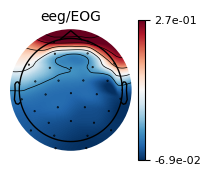

In [ ]:
# Pick EEG and EOG channels
# raw.pick_types(eeg=True, eog=True, exclude=[])

# Set EEG reference and filter data
raw.set_eeg_reference('average')
# Highpass filter to eliminate slow drifts
raw.filter(0.3, None, picks= ['eeg', 'eog'])

# Create EOG epochs
eog_epochs = create_eog_epochs(raw)  # This automatically detects EOG events
# eog_epochs.apply_baseline((0, 0))  # Baseline correction, if necessary

# Perform regression to get correction coefficients
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_epochs)

fig = model_plain.plot()

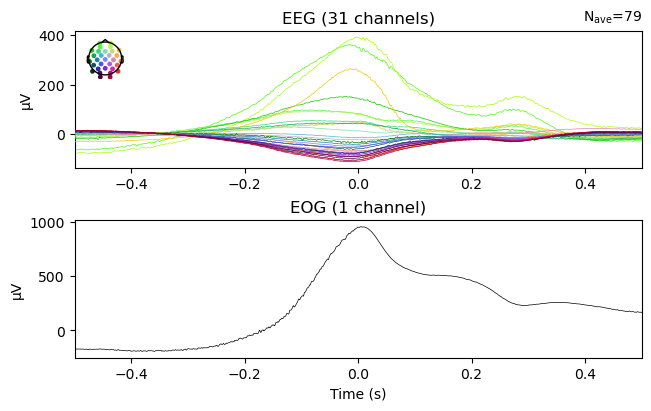

In [ ]:
# we'll try to keep a consistent ylim across figures
plot_kwargs = dict(picks=["eeg","eog"])

# plot the evoked for the EEG and the EOG sensors
fig = eog_epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

No projector specified for this dataset. Please consider the method self.add_proj.


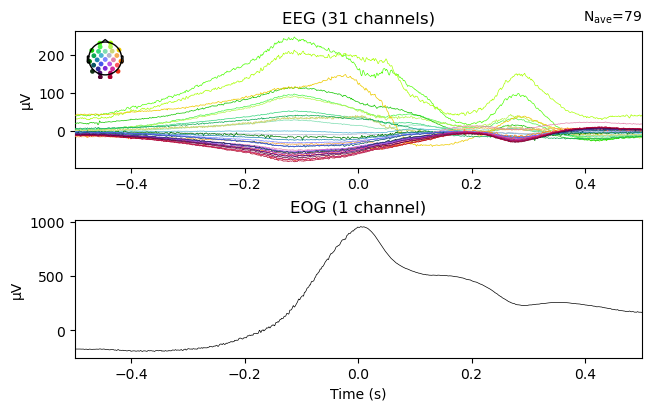

In [ ]:
epochs_clean_plain = model_plain.apply(eog_epochs)
# epochs_clean_plain.apply_baseline()
fig = epochs_clean_plain.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

In [ ]:
# eog_epochs = mne.preprocessing.create_eog_epochs(raw)
# # We need to explicitly specify that we want to average the EOG channel too.
# eog_evoked = eog_epochs.average(["eeg", "eog"])
# eog_evoked.plot(["eeg", "eog"])
# fig.set_size_inches(6, 6)

# # perform regression on the evoked blink response
# model_evoked = EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_evoked)
# fig = model_evoked.plot(vlim=(None, 0.4))
# fig.set_size_inches(3, 2)

# # for good measure, also show the effect on the blink evoked
# eog_evoked_clean = model_evoked.apply(eog_evoked)
# # eog_evoked_clean.apply_baseline()
# eog_evoked_clean.plot("all")
# fig.set_size_inches(6, 6)

In [ ]:
raw.plot(title='Before')
raw_clean = model_plain.apply(raw)
# raw_clean.apply_baseline()
raw_clean.plot(title='After')

No projector specified for this dataset. Please consider the method self.add_proj.


In [ ]:
# # Apply the regression to remove EOG artifacts
# raw_corrected = model.apply(raw)

# # Optionally, save the cleaned data
# # raw_corrected.save('path_to_save_cleaned_raw.fif', overwrite=True)

# # Visualize the effect
# raw.plot(title="Before EOG correction")
# raw_corrected.plot(title="After EOG correction")